Weight Uncertainty in Neural Networks, Blundell et. al.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import torch
import time
import math
import experiments.toy_regression as exp

C:\Users\flose\anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cpu")

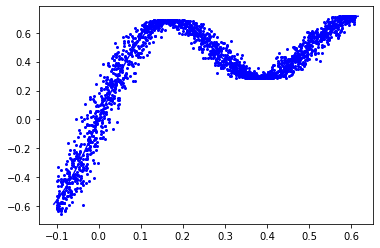

In [3]:
from training import toy

torch.manual_seed(42)

batch_size = 200

trainset = toy.TrigonometricToyDataset(sample_count=2000, noise=0.02, normalize=False, min=-0.1, max=0.61)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

trainset.plot_dataset()

In [37]:
from training.bbb import MixturePrior

batch_size = 200
noise = torch.tensor(0.02).to(device) # 3, 0.02
layers = [
    (1, 16),
    (16, 16),
    (16, 16),
    (16, 1)
]
learn_var = False
prior = MixturePrior(0.25, torch.exp(torch.tensor(-0)), torch.exp(torch.tensor(-6)), validate_args=True)

In [44]:
torch.manual_seed(42)
bbb = exp.bbb(layers, noise, learn_var, 500, trainloader, batch_size, device, layer_samples=1, global_samples=5, prior=prior, sampling="parameters")

Generated model: Sequential(
  (0): BBBLinear()
  (1): ReLU()
  (2): BBBLinear()
  (3): ReLU()
  (4): BBBLinear()
  (5): ReLU()
  (6): BBBLinear()
)
Epoch 0: loss 0.6579865217208862
Epoch 10: loss 0.693859875202179
Epoch 20: loss 0.6883275508880615
Epoch 30: loss 0.6831812858581543
Epoch 40: loss 0.6803675293922424
Epoch 50: loss 0.6787383556365967
Epoch 60: loss 0.6804869174957275
Epoch 70: loss 0.6805225610733032
Epoch 80: loss 0.681780993938446
Epoch 90: loss 0.6826419830322266
Epoch 100: loss 0.6795211434364319
Epoch 110: loss 0.6813720464706421
Epoch 120: loss 0.6791174411773682
Epoch 130: loss 0.6834063529968262
Epoch 140: loss 0.6810154914855957
Epoch 150: loss 0.6794087290763855
Epoch 160: loss 0.6815966367721558
Epoch 170: loss 0.6813279986381531
Epoch 180: loss 0.6791417002677917
Epoch 190: loss 0.6804534792900085
Epoch 200: loss 0.6802783608436584
Epoch 210: loss 0.6813900470733643
Epoch 220: loss 0.6792463660240173
Epoch 230: loss 0.6795341372489929
Epoch 240: loss 0.678737

In [ ]:
torch.manual_seed(42)
intel_bbb = exp.intel_bbb(layers, noise, learn_var, 900, trainloader, batch_size)

In [19]:
torch.manual_seed(42)
gp = exp.gaussian_process(100, trainset.normalized_xs, trainset.normalized_ys)

Epoch 0: loss 0.772654116153717
Epoch 20: loss -0.09803888201713562
Epoch 40: loss -0.9695585370063782
Epoch 60: loss -1.2259176969528198
Epoch 80: loss -1.2332572937011719


C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1687: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.. Using symeig method.
  warnings.warn(


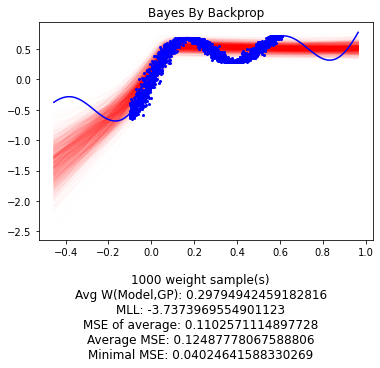

In [49]:
trainset.plot("Bayes By Backprop", bbb, gp, alpha=0.01, samples=1000, extra_range=0.5)

In [35]:
from training.bbb_blundell import BayesianNetwork

def train(net, optimizer, loader):
    #net.train()
    total_loss = torch.tensor(0, dtype=torch.float)

    for (data, target) in loader:
        net.zero_grad()
        x = data.reshape((-1, 1))
        y = target.reshape((-1,1))
        loss = net.BBB_loss(x, y)
        total_loss += loss
        loss.backward()
        optimizer.step()
    print(f"Loss: {total_loss / (len(loader) * batch_size)}")

net = BayesianNetwork(inputSize = 1,\
                    CLASSES = 1, \
                    layers=np.array([16,16,16]), \
                    activations = np.array(['relu','relu','relu','none']), \
                    SAMPLES = 5, \
                    BATCH_SIZE = batch_size,\
                    NUM_BATCHES = 2000 / batch_size,\
                    hasScalarMixturePrior = True,\
                    PI = 0.25,\
                    SIGMA_1 = torch.exp(torch.tensor(-0)),\
                    SIGMA_2 = torch.exp(torch.tensor(-6)),\
                    GOOGLE_INIT= False)

optimizer = torch.optim.SGD(net.parameters(),lr=1e-3,momentum=0.95)

for epoch in range(500):
    if (epoch)%10 == 0:
        print('Epoch: ', epoch)
    train(net, optimizer,trainloader)

Epoch:  0
Loss: 0.7099691033363342
Loss: 0.7172505259513855
Loss: 0.730191707611084
Loss: 0.735849142074585
Loss: 0.7351770997047424
Loss: 0.731894314289093
Loss: 0.732814610004425
Loss: 0.7337101101875305
Loss: 0.7343512773513794
Loss: 0.7199236154556274
Epoch:  10
Loss: 0.7141148447990417
Loss: 0.7118432521820068
Loss: 0.7104840278625488
Loss: 0.709637463092804
Loss: 0.7095156908035278
Loss: 0.708965003490448
Loss: 0.7083836197853088
Loss: 0.708791196346283
Loss: 0.7081587910652161
Loss: 0.7074657082557678
Epoch:  20
Loss: 0.7096856832504272
Loss: 0.7085466384887695
Loss: 0.7065505981445312
Loss: 0.7055251002311707
Loss: 0.7061659097671509
Loss: 0.7044186592102051
Loss: 0.7052895426750183
Loss: 0.7049198150634766
Loss: 0.7055035829544067
Loss: 0.7054018974304199
Epoch:  30
Loss: 0.7063055038452148
Loss: 0.7038279175758362
Loss: 0.7036700248718262
Loss: 0.7039455771446228
Loss: 0.701316773891449
Loss: 0.7007117867469788
Loss: 0.6994614601135254
Loss: 0.6985432505607605
Loss: 0.7003741

C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1687: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.. Using symeig method.
  warnings.warn(


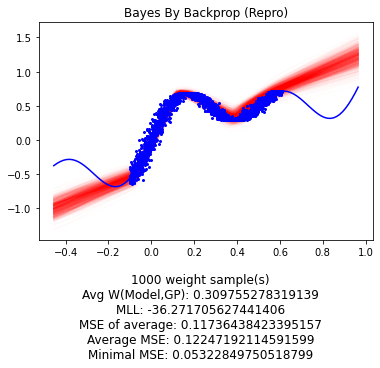

In [46]:
def eval_blundell(input, samples):
    net.eval()
    return [(net(input), torch.tensor(0.02)) for _ in range(samples)]

trainset.plot("Bayes By Backprop (Repro)", eval_blundell, gp, alpha=0.01, samples=1000, extra_range=0.5)